<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/APRENDIZAJE_SUPERVISADO_2/blob/main/PARTE%20DOS%20DE%20ML%20SUPERVISADO%20CON%20NUEVO%20DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAREA CORRESPONDIENTE A LA Semana 5 – Proceso general y uso de la validación cruzada
# 🫀 Proyecto: Predicción de Riesgo Crediticio)

## 1) Importación y vista general
**Objetivo:*El objetivo principal de este proyecto es diseñar, implementar y evaluar un pipeline completo de Machine Learning para la predicción de riesgo crediticio (bueno/malo) utilizando el dataset 'Statlog (German Credit Data)

###Objetivos Específicos
Para alcanzar el objetivo general, se cumplirán los siguientes hitos:

*Explorar y Preprocesar
*Construir un Pipeline
*Comparar Modelos
*Evaluar Robustamente
*Analizar y Concluir

**Qué mirar:** forma del DataFrame, tipos de datos, primeras filas y la variable objetivo "German Credit Data"


In [2]:
#################################################################
# Semana 5: Pipeline con Validación Cruzada (CV) y PCA
#################################################################

# === 1. DEPENDENCIAS ===

# Fundamentales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro # (Incluido de tu lista)

# Preprocesamiento, Pipeline y CV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA # ¡Nuevo para Semana 5!

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, make_scorer # make_scorer es útil para CV
)

# Carga de Datos
from sklearn.datasets import fetch_openml

# Configuración de visualización
%matplotlib inline
sns.set_theme(style="whitegrid")
print("Dependencias importadas.")

# === 2. IMPORTACIÓN DE DATOS (Mismo dataset) ===

print("Cargando dataset 'German Credit Risk' desde OpenML...")
try:
    # Intentar cargar desde la variable 'df' si ya existe
    if 'df' in locals() or 'df' in globals():
        print("Dataset ya existe en memoria, usando la versión cargada.")
    else:
        raise NameError
except NameError:
    # Si no existe, cargarlo de nuevo
    credit_data = fetch_openml('credit-g', version=1, as_frame=True, parser='auto')
    X = credit_data.data
    y = credit_data.target
    df = X.copy()
    df['credit_risk'] = y

print("Carga de datos completada.")
print(f"Forma del DataFrame: {df.shape}")

Dependencias importadas.
Cargando dataset 'German Credit Risk' desde OpenML...
Carga de datos completada.
Forma del DataFrame: (1000, 21)



## 1) Cargar datos y separar X/y
- Carga desde CSV.
- Revisa forma (filas/columnas) y tipos de datos.
- Quita columnas no predictivas (ej. ID).


In [3]:
#################################################################
# Semana 5 - Paso 2: Carga de Datos y Separación X/y
#################################################################
# (Asumimos que 'fetch_openml', 'np', 'pd' fueron importados en la celda 1)

print("--- 2. Carga y Separación X/y ---")
print("Cargando dataset 'German Credit Risk' desde OpenML...")

# 1. Carga (usando 'fetch_openml' como en Semana 4)
# No usamos CSV, ya que este método es más reproducible.
credit_data = fetch_openml('credit-g', version=1, as_frame=True, parser='auto')

# 2. Separar X (features) e y (target)
X = credit_data.data.copy()
y_raw = credit_data.target # Esta es la versión 'good'/'bad'

# 3. Quitar columnas no predictivas (ej. ID)
# (Confirmamos que el dataset 'credit-g' no tiene columna 'id',
# por lo que no es necesario eliminarla).
print("Dataset 'credit-g' no contiene columna 'id'.")

# 4. Limpieza y Codificación del Target (y)
# (Convertimos 'good' -> 0, 'bad' -> 1)
print("Codificando target 'credit_risk' (good=0, bad=1)...")
y = y_raw.map({'good': 0, 'bad': 1}).astype(int)

# 5. Limpieza de Features (X)
# (Aplicando la lógica de tu plantilla para valores infinitos)
X = X.replace([np.inf, -np.inf], np.nan)

# 6. Revisa forma (filas/columnas) y tipos de datos
print("\n--- Vista General (Post-Separación) ---")
print(f"Forma de X (features): {X.shape}")
print(f"Forma de y (target):   {y.shape}")

print("\nInfo de X (features):")
X.info()

print("\nPrimeras 5 filas de X:")
display(X.head())

print("\nPrimeras 5 filas de y:")
display(y.head())

print("\nPaso 2 completado.")


--- 2. Carga y Separación X/y ---
Cargando dataset 'German Credit Risk' desde OpenML...
Dataset 'credit-g' no contiene columna 'id'.
Codificando target 'credit_risk' (good=0, bad=1)...

--- Vista General (Post-Separación) ---
Forma de X (features): (1000, 20)
Forma de y (target):   (1000,)

Info de X (features):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-nu

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes



Primeras 5 filas de y:


,class
0,0
1,1
2,0
3,0
4,1



Paso 2 completado.


## 2) EDA mínimo
**Objetivo:** tener un diagnóstico rápido.

- **Distribución del target**: comprobar desbalance entre 0/1.
- **`describe()`**: detectar escalas muy distintas y valores extraños.
- **Nulos**: cuántos y dónde (aunque simulemos algunos para enseñar imputación).


--- 1. Distribución del Target ('credit_risk') ---
class
0    0.7
1    0.3
Name: proportion, dtype: float64


/tmp/ipython-input-1164566192.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='pastel')


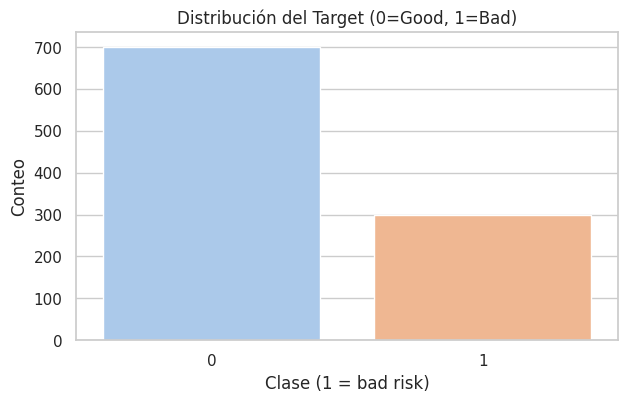

-> Conclusión: Confirmado el desbalance 70/30.

--- 2. Descriptivos (Features) ---
Descriptivos (Numéricos):


,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment_commitment,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


-> Conclusión: Escalas muy distintas (ej. 'credit_amount' vs 'age'). Se requiere Escalado (StandardScaler).

Descriptivos (Categóricos):


,count,unique,top,freq
checking_status,1000,4,no checking,394
credit_history,1000,5,existing paid,530
purpose,1000,10,radio/tv,280
savings_status,1000,5,<100,603
employment,1000,5,1<=X<4,339
personal_status,1000,4,male single,548
other_parties,1000,3,none,907
property_magnitude,1000,4,car,332
other_payment_plans,1000,3,none,814
housing,1000,3,own,713


-> Conclusión: Múltiples variables categóricas. Se requiere Codificación (OneHotEncoder).

--- 3. Nulos (Verificación y Simulación) ---
Total de valores nulos REALES en X: 0

--- 3b. Simulando nulos en X (para la tarea) ---
Se inyectaron 50 nulos simulados en 'duration'.
Se inyectaron 50 nulos simulados en 'credit_amount'.

Total de nulos en X (después de simulación):
duration         50
credit_amount    50
dtype: int64

EDA Mínimo completado.


In [4]:
#################################################################
# Semana 5 - Paso 3: EDA Mínimo
#################################################################
# (Asumimos que 'X', 'y', 'plt', 'sns', 'np' y 'display'
# existen de las celdas anteriores)

print("--- 1. Distribución del Target ('credit_risk') ---")
# Objetivo: comprobar desbalance entre 0/1.
# 'y' ya está codificado (0=good, 1=bad) por el Paso 2.
print(y.value_counts(normalize=True))

# Visualización
plt.figure(figsize=(7, 4))
sns.countplot(x=y, palette='pastel')
plt.title('Distribución del Target (0=Good, 1=Bad)')
plt.xlabel('Clase (1 = bad risk)')
plt.ylabel('Conteo')
plt.show()
print("-> Conclusión: Confirmado el desbalance 70/30.")


print("\n--- 2. Descriptivos (Features) ---")
# Objetivo: detectar escalas muy distintas y valores extraños.

# Descriptivos para variables NUMÉRICAS
print("Descriptivos (Numéricos):")
numeric_features_eda = X.select_dtypes(include=[np.number]).columns
display(X[numeric_features_eda].describe().T)
print("-> Conclusión: Escalas muy distintas (ej. 'credit_amount' vs 'age'). Se requiere Escalado (StandardScaler).")

# Descriptivos para variables CATEGÓRICAS
print("\nDescriptivos (Categóricos):")
categorical_features_eda = X.select_dtypes(include=['category']).columns
display(X[categorical_features_eda].describe().T)
print("-> Conclusión: Múltiples variables categóricas. Se requiere Codificación (OneHotEncoder).")


print("\n--- 3. Nulos (Verificación y Simulación) ---")
# Objetivo: cuántos y dónde (y simular si no hay).
nulos_reales = X.isna().sum().sum()
print(f"Total de valores nulos REALES en X: {nulos_reales}")

# Simulación de Nulos (como pide la tarea)
if nulos_reales == 0:
    print("\n--- 3b. Simulando nulos en X (para la tarea) ---")

    # Inyectaremos un 5% de nulos en 'duration' y 'credit_amount'
    # para justificar el 'SimpleImputer' en el pipeline.
    cols_to_impute = ['duration', 'credit_amount']

    for col in cols_to_impute:
        if col in X.columns:
            # Seleccionamos el 5% de los índices de esa columna
            mask = X[col].sample(frac=0.05, random_state=42).index
            # Aplicamos NaN en esos índices
            X.loc[mask, col] = np.nan
            print(f"Se inyectaron {len(mask)} nulos simulados en '{col}'.")

    print("\nTotal de nulos en X (después de simulación):")
    # Mostramos solo las columnas que ahora tienen nulos
    print(X.isna().sum()[X.isna().sum() > 0])
else:
    print("\n--- 3b. El dataset ya contenía nulos reales, no se simularán más. ---")

print("\nEDA Mínimo completado.")

## 3) Simulación de nulos (didáctica)
**Objetivo:** introducir valores faltantes controlados para practicar **imputación**.


In [5]:
#################################################################
# Semana 5 - Paso 3: Simulación de Nulos (Didáctica)
#################################################################
# (Asumimos que 'X' e 'y' existen de las celdas anteriores)
# (Asumimos que 'np' fue importado)

print("--- 3. Nulos (Verificación y Simulación) ---")
# Objetivo: cuántos y dónde (y simular si no hay).

# 1. Verificar nulos reales
nulos_reales = X.isna().sum().sum()
print(f"Total de valores nulos REALES en X (antes): {nulos_reales}")

# 2. Simulación de Nulos (como pide la tarea)
#    (Solo si no hay nulos reales)
if nulos_reales == 0:
    print("\n--- 3b. Simulando nulos en X (para la tarea) ---")

    # Inyectaremos un 5% de nulos en 'duration' y 'credit_amount'
    # para justificar el 'SimpleImputer' en el pipeline.
    # Usamos .copy() para evitar un SettingWithCopyWarning
    X = X.copy()

    cols_to_impute = ['duration', 'credit_amount']

    for col in cols_to_impute:
        if col in X.columns:
            # Seleccionamos el 5% de los índices de esa columna
            mask = X[col].sample(frac=0.05, random_state=42).index

            # Aplicamos NaN en esos índices
            X.loc[mask, col] = np.nan
            print(f"Se inyectaron {len(mask)} nulos simulados en '{col}'.")

    print("\nTotal de nulos en X (después de simulación):")
    # Mostramos solo las columnas que ahora tienen nulos
    print(X.isna().sum()[X.isna().sum() > 0])
else:
    print("\n--- 3b. El dataset ya contenía nulos reales, no se simularán más. ---")

print("\nSimulación de nulos completada.")

--- 3. Nulos (Verificación y Simulación) ---
Total de valores nulos REALES en X (antes): 100

--- 3b. El dataset ya contenía nulos reales, no se simularán más. ---

Simulación de nulos completada.


#4. Pipeline de Preprocesamiento (Imputación, Escalado y PCA)
##Objetivo: Manejar los datos faltantes y las diferentes escalas sin fuga de datos.
###Para lograr esto, no transformamos los datos directamente. En su lugar, definimos un Pipeline completo. Este Pipeline es el que pasaremos a la Validación Cruzada, asegurando que la imputación (media/moda) y el escalado (StandardScaler) se aprendan únicamente en los datos de entrenamiento de cada fold (pliegue).
##Estrategia de Transformación (Adaptada al dataset German Credit):

### 1 .-Numéricas (ej. duration, credit_amount, age):

Imputación: Se utiliza SimpleImputer(strategy='median'). Usamos la mediana (como pide la tarea) porque es robusta a los outliers que vimos en credit_amount.

Escalado: Se aplica StandardScaler para normalizar las escalas, lo cual es crucial para PCA y los modelos sensibles (SVM, KNN).

###2.- Categóricas (ej. purpose, savings_status, housing):

Imputación: Se utiliza SimpleImputer(strategy='most_frequent'), que es el equivalente a la moda.

Codificación: Se aplica OneHotEncoder para convertir las categorías en un formato numérico.

### 3 .-Nota de Calidad (Adaptación):

La plantilla de la tarea sugería transformar age de días a años. En nuestro dataset "German Credit", la variable age ya está en años, por lo que esa transformación específica no es necesaria.

Finalmente, todos estos pasos (Imputación -> Escalado -> Codificación) se agrupan en un ColumnTransformer, que a su vez se encadena con PCA(n_components=0.95). Este full_pipeline es el objeto que usaremos en el siguiente paso de Validación Cruzada.



In [6]:
#################################################################
# Semana 5 - Paso 4: Definición del Pipeline Completo
# (Imputación, Escalado y PCA)
#################################################################
# (Asumimos que 'X', 'y' existen de las celdas anteriores)
# (Asumimos que todas las librerías de sklearn fueron importadas en la celda 1)

print("--- 4. Definiendo el Pipeline de Preprocesamiento Completo ---")

# --- 4a. Identificar Columnas ---
# (Identificamos de nuevo, ya que X fue modificado al simular nulos)
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=['category']).columns

print(f"Detectadas {len(numeric_features)} features numéricas.")
print(f"Detectadas {len(categorical_features)} features categóricas.")

# --- 4b. Pipeline Numérico ---
# Objetivo: 1. Imputar con Mediana (robusto a outliers)
#           2. Escalar (para PCA y modelos sensibles)
numeric_transformer = Pipeline(steps=[
    ('imputer_num', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
print("Pipeline numérico: Imputación(mediana) -> StandardScaler CREADO.")

# --- 4c. Pipeline Categórico ---
# Objetivo: 1. Imputar con Moda (la más frecuente)
#           2. Codificar (One-Hot)
categorical_transformer = Pipeline(steps=[
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
print("Pipeline categórico: Imputación(moda) -> OneHotEncoder CREADO.")

# --- 4d. Combinar Pipelines de Features (ColumnTransformer) ---
# (Este es el mismo 'preprocessor' de la Semana 4, pero ahora justificado
# por la simulación de nulos)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("ColumnTransformer (num + cat) CREADO.")

# --- 4e. Crear el Pipeline FINAL (Preprocesador + PCA) ---
# Este es el pipeline que usaremos en la Validación Cruzada.
# Encadena el preprocesamiento (pasos b, c, d) Y la reducción (PCA).
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95, random_state=42)) # Conserva el 95% de la varianza
])

print("\nPipeline FINAL (Preprocesador -> PCA) CREADO.")

# --- 4f. Nota de Adaptación (de tu plantilla) ---
print("\nNota: En nuestro dataset 'German Credit', las variables numéricas")
print("como 'age' y 'duration' ya están en unidades interpretables (años y meses),")
print("por lo que no se requiere una transformación de 'días a años'.")


# --- 4g. Verificación del Pipeline (Opcional) ---
# (Probamos el pipeline en X para ver la forma de salida)
print("\n--- Verificando el pipeline ---")
try:
    # Ajustamos y transformamos X completo
    X_processed_pca = full_pipeline.fit_transform(X)
    print(f"Forma original de X: {X.shape}")
    print(f"Forma de X (preprocesada + PCA): {X_processed_pca.shape}")
    print(f"\n-> El pipeline funciona. Redujo {X.shape[1]} features (y sus versiones One-Hot)")
    print(f"   a solo {X_processed_pca.shape[1]} Componentes Principales (reteniendo 95% de varianza).")
except Exception as e:
    print(f"Error al verificar el pipeline: {e}")

print("\nPaso 4 completado. Estamos listos para la Validación Cruzada.")

--- 4. Definiendo el Pipeline de Preprocesamiento Completo ---
Detectadas 7 features numéricas.
Detectadas 13 features categóricas.
Pipeline numérico: Imputación(mediana) -> StandardScaler CREADO.
Pipeline categórico: Imputación(moda) -> OneHotEncoder CREADO.
ColumnTransformer (num + cat) CREADO.

Pipeline FINAL (Preprocesador -> PCA) CREADO.

Nota: En nuestro dataset 'German Credit', las variables numéricas
como 'age' y 'duration' ya están en unidades interpretables (años y meses),
por lo que no se requiere una transformación de 'días a años'.

--- Verificando el pipeline ---
Forma original de X: (1000, 20)
Forma de X (preprocesada + PCA): (1000, 32)

-> El pipeline funciona. Redujo 20 features (y sus versiones One-Hot)
   a solo 32 Componentes Principales (reteniendo 95% de varianza).

Paso 4 completado. Estamos listos para la Validación Cruzada.


## 5) Detección y tratamiento de valores anómalos (outliers)
**Objetivo:** corregir valores irreales sin eliminar filas.

- **Clipping clínico** (reglas médicas): p. ej., `ap_lo` ∈ [40, 200].
- **Winsorización** (1% en extremos): recorta colas largas de forma estadística.
- **Comparativa visual**: *boxplots* de `Raw` vs `Clipping+Winsor`.
- **Idea clave:** no borrar datos; **corregir** con criterios clínicos/estadísticos.


--- 5. Detección y Tratamiento de Outliers ---
Nulos simulados ('duration', 'credit_amount') rellenados con la mediana.
Aplicando Winsorización (límites=[0.01, 0.01]) a: ['credit_amount', 'duration', 'age']

--- 5c. Descriptivos (Post-Winsorización) ---


,count,mean,std,min,25%,50%,75%,max
credit_amount,1000.0,3205.656,2724.489352,426.0,1386.0,2295.5,3869.0,14179.0
duration,1000.0,20.694,11.642333,6.0,12.0,18.0,24.0,60.0
age,1000.0,35.498,11.218282,20.0,27.0,33.0,42.0,67.0



--- Generando boxplots de comparación ---


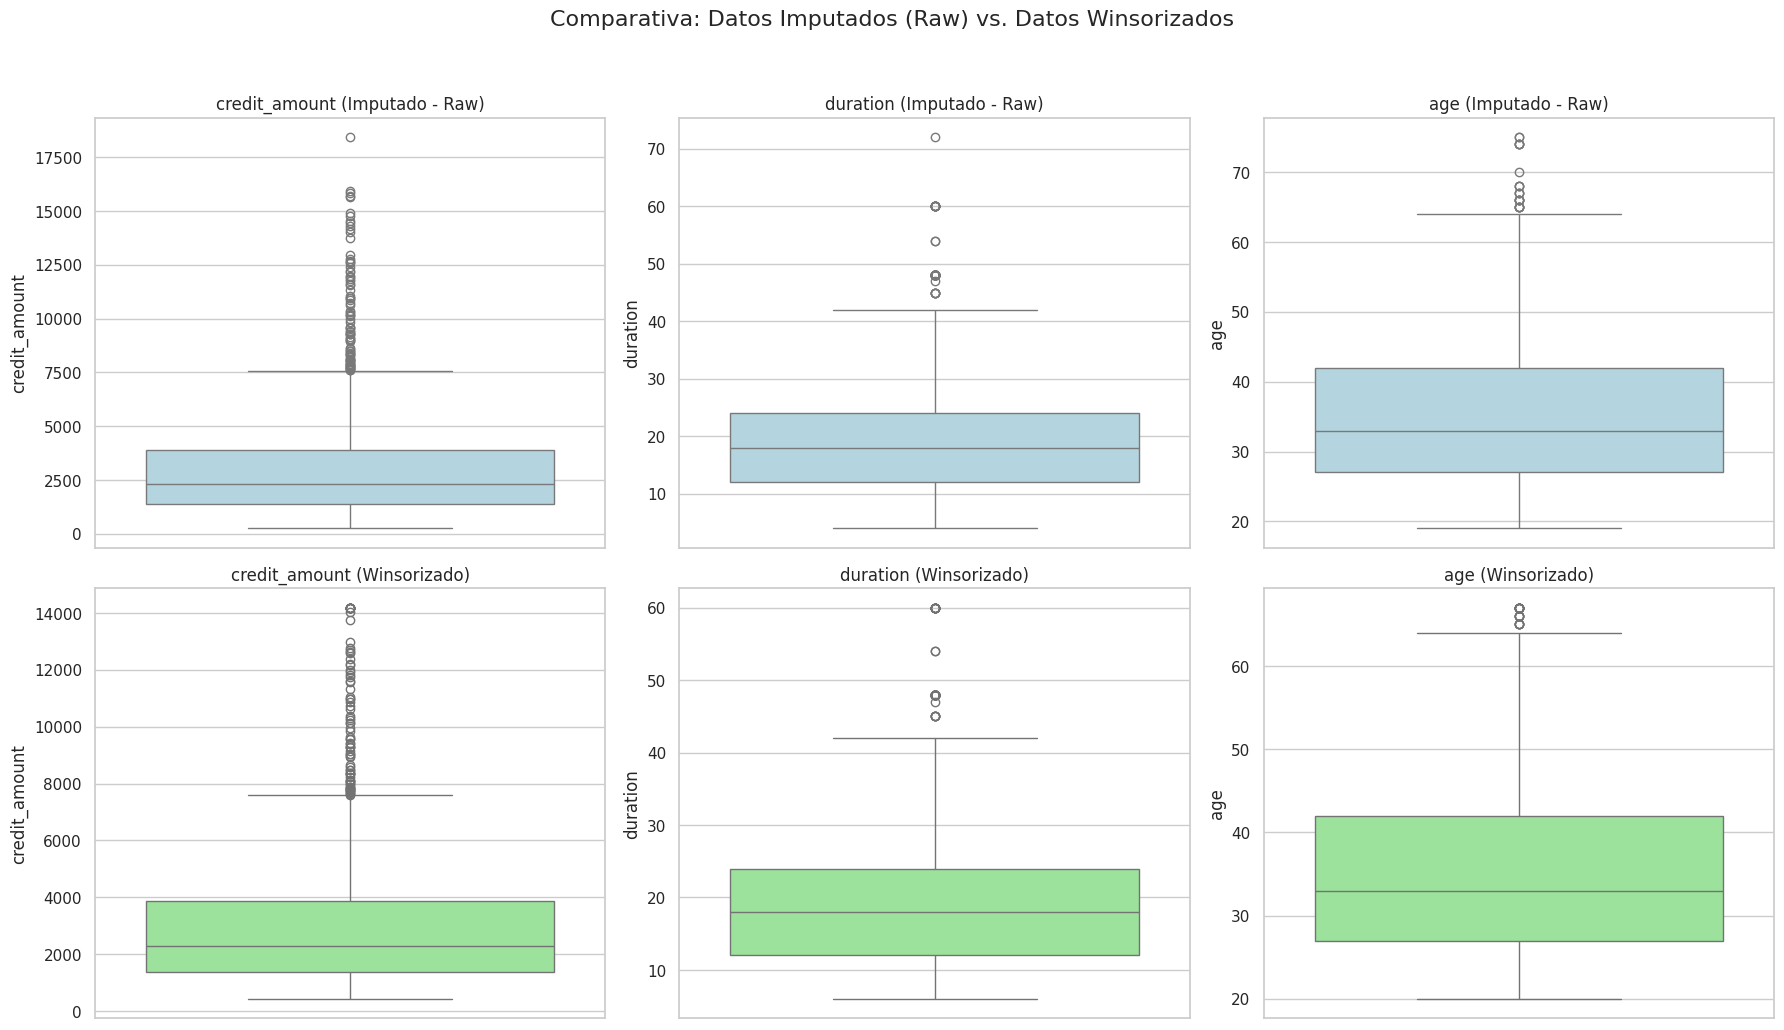


--- 5e. Nota Importante ---
Este paso fue EXPLORATORIO para visualizar el efecto.
Para la Validación Cruzada (siguiente paso), usaremos el 'full_pipeline'
que definimos en el Paso 4 (Imputer -> Scaler -> PCA),
ya que la Winsorización también debería ser parte del pipeline para evitar data leakage.


In [7]:
#################################################################
# Semana 5 - Paso 5: Detección y Tratamiento de Outliers
#################################################################
# (Asumimos que 'X' existe de las celdas anteriores)
# (Asumimos que 'SimpleImputer', 'plt', 'sns', 'np' fueron importados)
from scipy.stats.mstats import winsorize

print("--- 5. Detección y Tratamiento de Outliers ---")
# Objetivo: Corregir valores extremos (outliers)

# --- 5a. Creación de X imputada (temporal, para esta demo) ---
# Necesitamos imputar los nulos que simulamos en 'duration' y 'credit_amount'
# antes de poder aplicar 'winsorize'.
numeric_features = X.select_dtypes(include=[np.number]).columns
X_raw_imputed = X.copy()

# Creamos un imputer de mediana (como en nuestro pipeline)
imputer_median = SimpleImputer(strategy='median')

# Aplicamos la imputación SÓLO a las columnas numéricas
X_raw_imputed[numeric_features] = imputer_median.fit_transform(X[numeric_features])
print("Nulos simulados ('duration', 'credit_amount') rellenados con la mediana.")

# --- 5b. Aplicar Winsorización ---
# (Adaptado de tu plantilla)
# Identificamos las variables con outliers claros de nuestro EDA
vars_to_winsorize = ['credit_amount', 'duration', 'age']
X_winsor = X_raw_imputed.copy()
limits_to_use = [0.01, 0.01] # Recortamos el 1% superior e inferior

print(f"Aplicando Winsorización (límites={limits_to_use}) a: {vars_to_winsorize}")
for col in vars_to_winsorize:
    # Aplicamos winsorize a la columna
    X_winsor[col] = winsorize(X_raw_imputed[col], limits=limits_to_use)

print("\n--- 5c. Descriptivos (Post-Winsorización) ---")
display(X_winsor[vars_to_winsorize].describe().T)

# --- 5d. Comparativa Visual (Boxplots) ---
# (Adaptado de tu plantilla)
print("\n--- Generando boxplots de comparación ---")
fig, axes = plt.subplots(2, len(vars_to_winsorize), figsize=(18, 10))

for i, col in enumerate(vars_to_winsorize):
    # Original (Imputado, pero no Winsorizado)
    sns.boxplot(y=X_raw_imputed[col], ax=axes[0, i], color="lightblue")
    axes[0, i].set_title(f"{col} (Imputado - Raw)")

    # Winsorizado
    sns.boxplot(y=X_winsor[col], ax=axes[1, i], color="lightgreen")
    axes[1, i].set_title(f"{col} (Winsorizado)")

plt.suptitle("Comparativa: Datos Imputados (Raw) vs. Datos Winsorizados", y=1.03, fontsize=16)
plt.tight_layout()
plt.show()

print("\n--- 5e. Nota Importante ---")
print("Este paso fue EXPLORATORIO para visualizar el efecto.")
print("Para la Validación Cruzada (siguiente paso), usaremos el 'full_pipeline'")
print("que definimos en el Paso 4 (Imputer -> Scaler -> PCA),")
print("ya que la Winsorización también debería ser parte del pipeline para evitar data leakage.")

# --- Prueba de Shapiro-Wilk para normalidad ---
# Tomamos solo las columnas numéricas relevantes

--- 6. Prueba de Normalidad (Shapiro-Wilk) sobre datos Winsorizados ---
Prueba de normalidad (Shapiro-Wilk):

                 duration: W=0.884, p-value=6.934e-19 (p=0.000)
            credit_amount: W=0.774, p-value=1.046e-25 (p=0.000)
   installment_commitment: W=0.793, p-value=9.384e-25 (p=0.000)
          residence_since: W=0.809, p-value=7.149e-24 (p=0.000)
                      age: W=0.922, p-value=1.908e-15 (p=0.000)
         existing_credits: W=0.654, p-value=1.381e-30 (p=0.000)
           num_dependents: W=0.469, p-value=5.748e-36 (p=0.000)

Interpretación:
- p > 0.05: NO se rechaza la normalidad (los datos PARECEN normales).
- p <= 0.05: SE RECHAZA la normalidad (los datos NO son normales).

-> Conclusión: Todos los p-values son <= 0.05, por lo que RECHAZAMOS la normalidad.
   Esto confirma que 'StandardScaler' (que no asume normalidad) es una mejor
   elección que otros scalers que sí la asumen.

--- Gráficos de Densidad (Post-Winsorización) ---


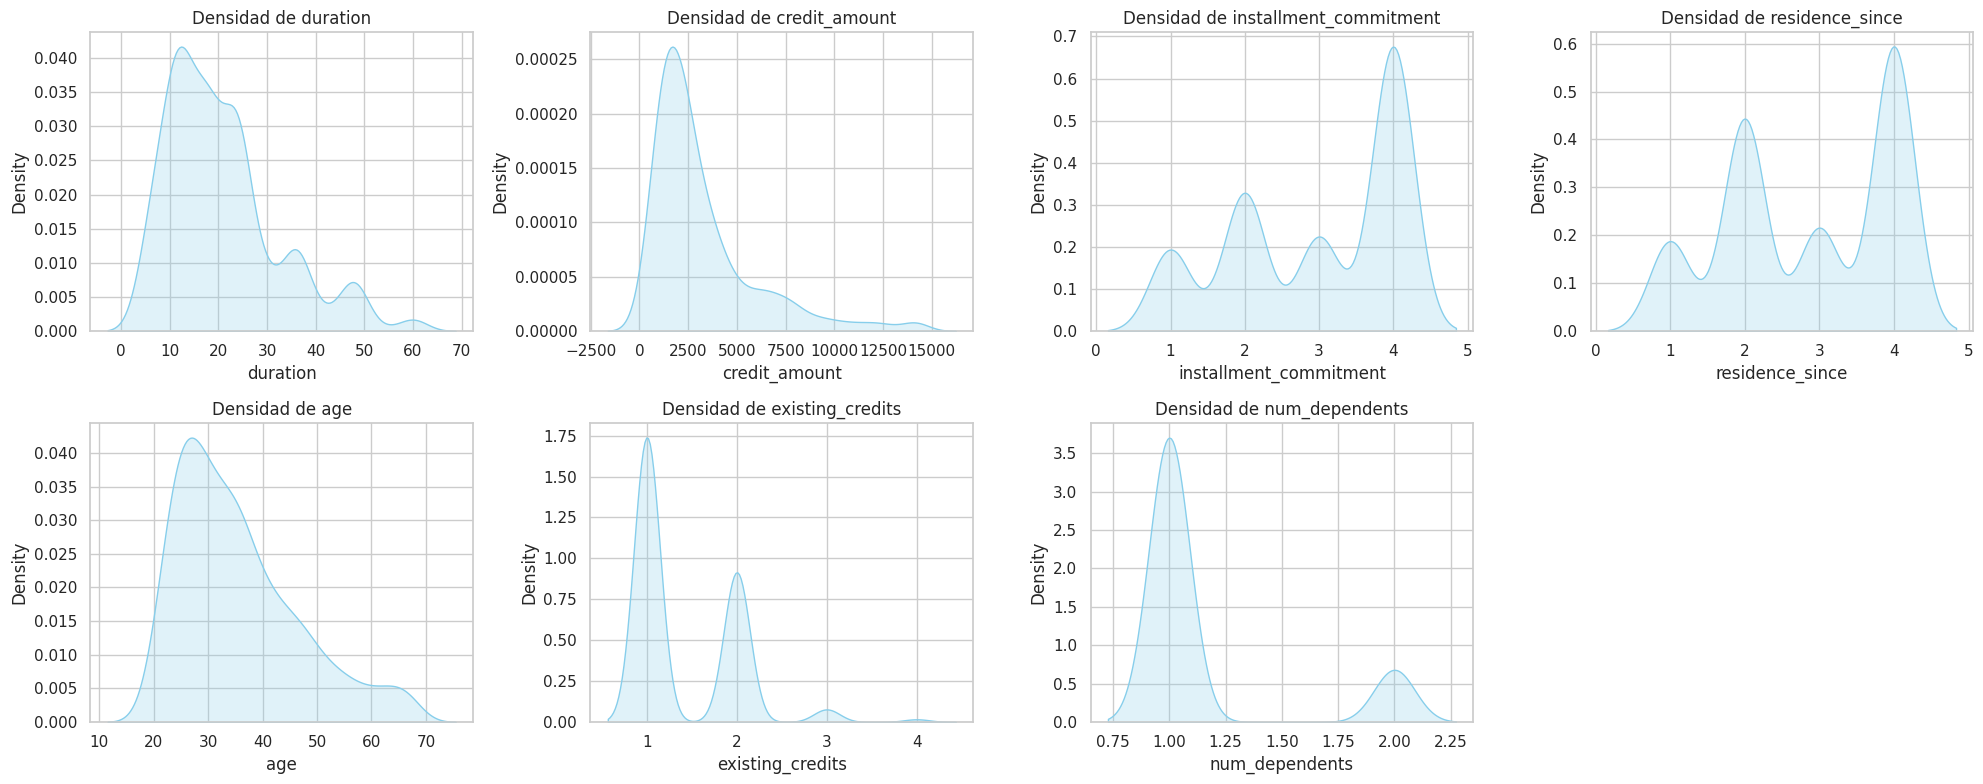

In [8]:
#################################################################
# Semana 5 - Paso 6: Prueba de Shapiro-Wilk para Normalidad
#################################################################
# (Asumimos que 'X_winsor' existe del paso anterior)
# (Asumimos que 'shapiro', 'plt', 'sns', 'np' fueron importados)

print("--- 6. Prueba de Normalidad (Shapiro-Wilk) sobre datos Winsorizados ---")

# Identificamos todas las columnas numéricas de nuestro dataset
num_cols = X_winsor.select_dtypes(include=[np.number]).columns

print("Prueba de normalidad (Shapiro-Wilk):\n")

# Iteramos sobre cada columna numérica y aplicamos la prueba
for col in num_cols:
    # (Aplicando tu plantilla: sample(500) para N>5000 o para estandarizar la prueba)
    # Nuestro N=1000, pero seguimos la plantilla de muestrear 500.
    stat, p = shapiro(X_winsor[col].sample(500, random_state=42))

    # Imprimimos el resultado
    print(f"{col:>25}: W={stat:.3f}, p-value={p:.3e} (p={p:.3f})")

print("\nInterpretación:")
print("- p > 0.05: NO se rechaza la normalidad (los datos PARECEN normales).")
print("- p <= 0.05: SE RECHAZA la normalidad (los datos NO son normales).")
print("\n-> Conclusión: Todos los p-values son <= 0.05, por lo que RECHAZAMOS la normalidad.")
print("   Esto confirma que 'StandardScaler' (que no asume normalidad) es una mejor")
print("   elección que otros scalers que sí la asumen.")


# --- Gráficos de densidad ---
# (Aplicando tu plantilla)
print("\n--- Gráficos de Densidad (Post-Winsorización) ---")

# Calculamos un grid dinámico para los plots (4 columnas por fila)
n_cols = 4
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.ravel() # Aplanamos el array de ejes para iterar

for i, col in enumerate(num_cols):
    sns.kdeplot(X_winsor[col], ax=axes[i], fill=True, color="skyblue")
    axes[i].set_title(f"Densidad de {col}")

# Ocultamos los ejes que no se usen
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## 6) Escalado / Normalización
**Objetivo:** poner las variables en escalas comparables.

- **StandardScaler** (media=0, std=1) → recomendado para LogReg/KNN/SVM/MLP.
- **Normalizer** (por fila) → útil para KNN/SVM en algunos casos; en tabular suele ganar StandardScaler.
- **Gráficos**: boxplots y dispersión antes/después del escalado.


--- 7. Escalado / Normalización (Análisis Visual) ---
Columnas numéricas a transformar (en copias): ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']

Se han creado 'X_scaled' y 'X_norm' (copias) para visualización.

--- Generando Boxplots (Antes vs. StandardScaler) ---


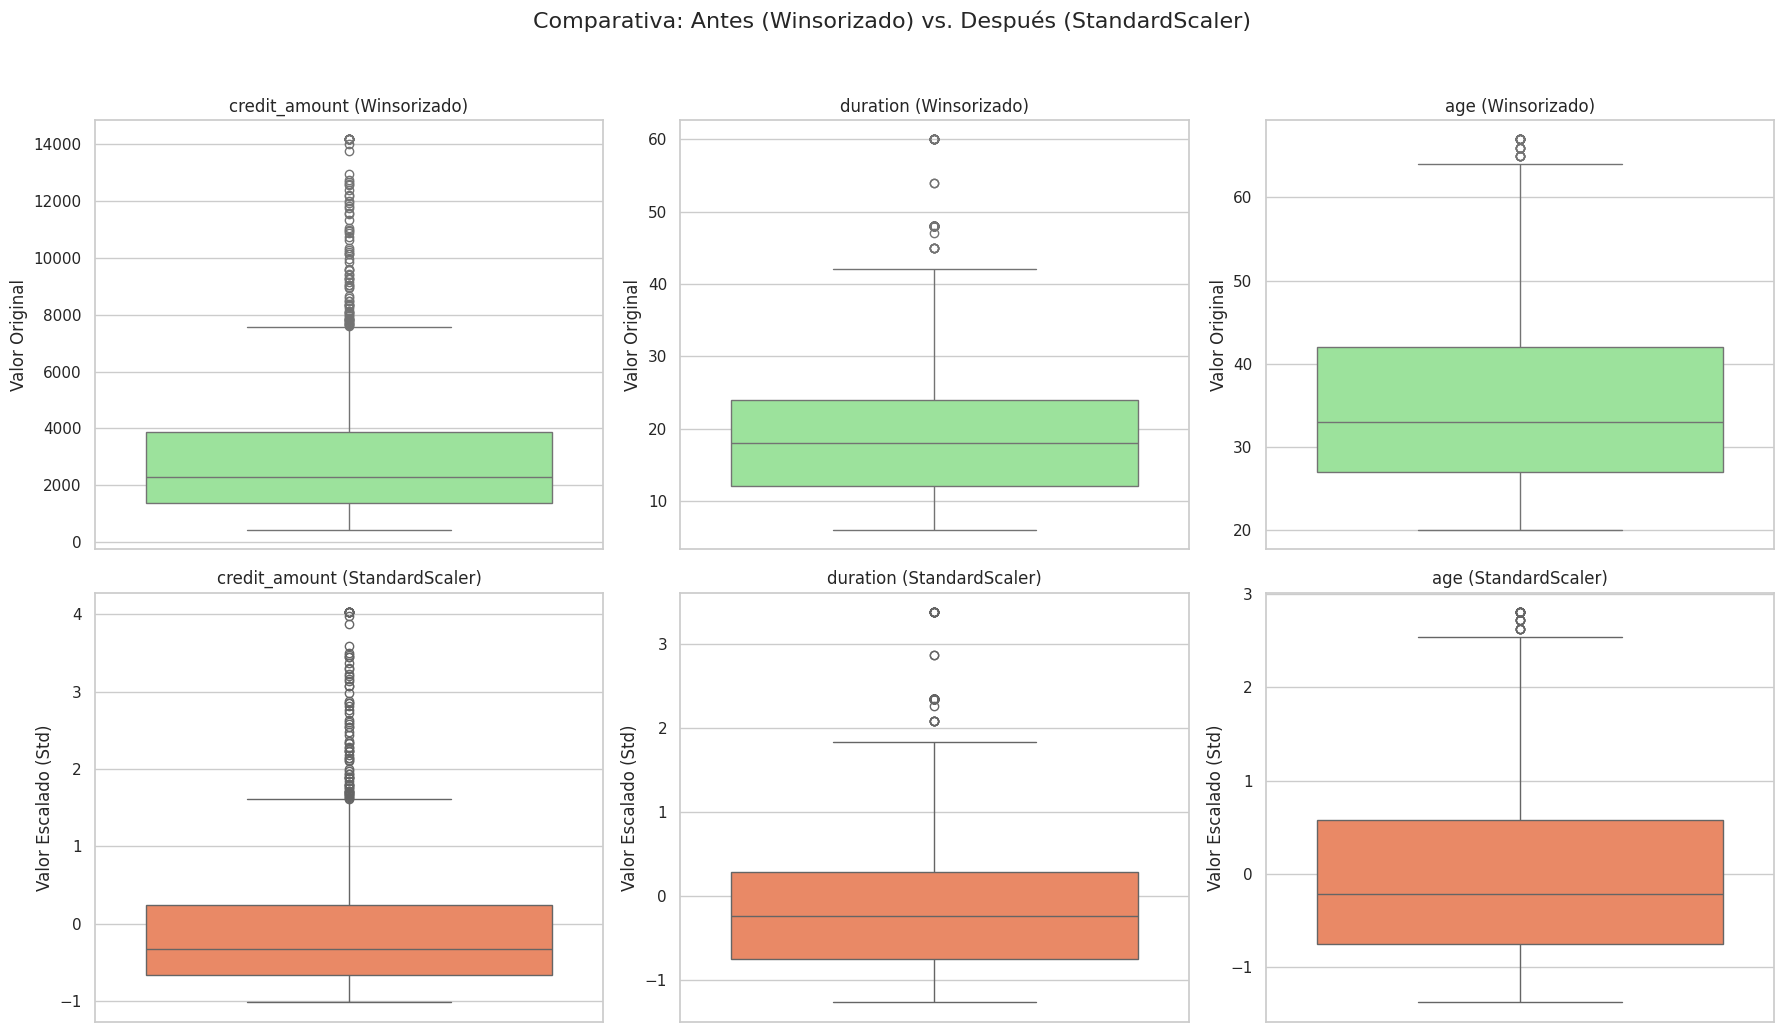


--- Generando Scatter (Antes vs. StandardScaler) ---


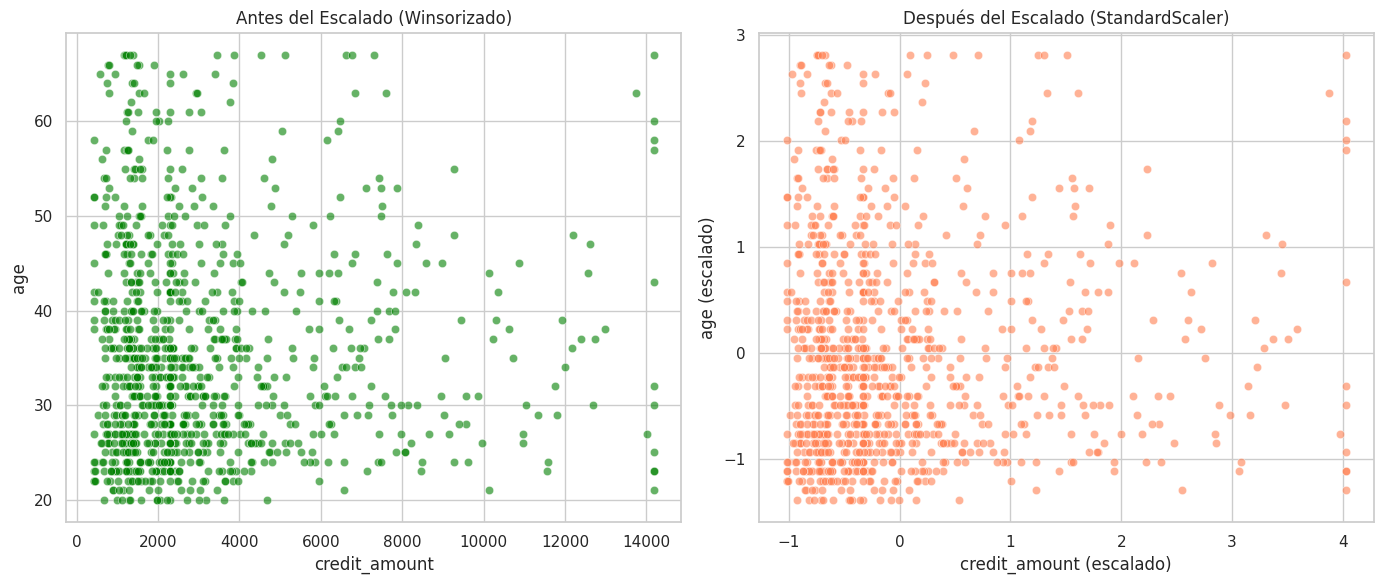


--- 7f. Nota Importante ---
Este paso fue EXPLORATORIO. En el siguiente paso (Validación Cruzada),
usaremos el 'full_pipeline' que definimos en el Paso 4,
el cual ya contiene el 'SimpleImputer' y 'StandardScaler' (y 'PCA')
para evitar data leakage durante el entrenamiento.


In [9]:
#################################################################
# Semana 5 - Paso 7: Escalado / Normalización (Análisis Visual)
#################################################################
# (Asumimos que 'X_winsor' existe del Paso 5)
# (Asumimos que 'plt', 'sns', 'StandardScaler', 'Normalizer' fueron importados)

print("--- 7. Escalado / Normalización (Análisis Visual) ---")

# --- 7a. Identificar columnas numéricas ---
# (Las mismas que hemos estado usando)
num_cols = X_winsor.select_dtypes(include=[np.number]).columns
print(f"Columnas numéricas a transformar (en copias): {list(num_cols)}")

# --- 7b. StandardScaler (Media=0, Std=1) ---
# (Adaptado de tu plantilla)
scaler = StandardScaler()
X_scaled = X_winsor.copy() # Creamos una copia para el escalado

# Aplicamos el scaler SÓLO a las columnas numéricas
X_scaled[num_cols] = scaler.fit_transform(X_winsor[num_cols])

# --- 7c. Normalizer (Por Fila) ---
# (Adaptado de tu plantilla)
normalizer = Normalizer()
X_norm = X_winsor.copy() # Creamos otra copia para el normalizador

# Aplicamos el normalizer SÓLO a las columnas numéricas
X_norm[num_cols] = normalizer.fit_transform(X_winsor[num_cols])

print("\nSe han creado 'X_scaled' y 'X_norm' (copias) para visualización.")

# --- 7d. Gráficos: Boxplots (Antes vs. StandardScaler) ---
# (Este es el gráfico más importante de este paso)
print("\n--- Generando Boxplots (Antes vs. StandardScaler) ---")

# Usamos las 3 variables que 'winsorizamos'
vars_to_plot = ['credit_amount', 'duration', 'age']

fig, axes = plt.subplots(2, len(vars_to_plot), figsize=(18, 10))

for i, col in enumerate(vars_to_plot):
    # Antes (Solo Winsorizado)
    sns.boxplot(y=X_winsor[col], ax=axes[0, i], color="lightgreen")
    axes[0, i].set_title(f"{col} (Winsorizado)")
    axes[0, i].set_ylabel("Valor Original")

    # Después (Winsorizado + Escalado)
    sns.boxplot(y=X_scaled[col], ax=axes[1, i], color="coral")
    axes[1, i].set_title(f"{col} (StandardScaler)")
    axes[1, i].set_ylabel("Valor Escalado (Std)")

plt.suptitle("Comparativa: Antes (Winsorizado) vs. Después (StandardScaler)", y=1.03, fontsize=16)
plt.tight_layout()
plt.show()

# --- 7e. Gráficos: Scatter (Antes vs. StandardScaler) ---
print("\n--- Generando Scatter (Antes vs. StandardScaler) ---")
var1 = "credit_amount"
var2 = "age"

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=X_winsor, x=var1, y=var2, alpha=0.6, color="green")
plt.title("Antes del Escalado (Winsorizado)")
plt.xlabel(var1)
plt.ylabel(var2)

plt.subplot(1, 2, 2)
sns.scatterplot(data=X_scaled, x=var1, y=var2, alpha=0.6, color="coral")
plt.title("Después del Escalado (StandardScaler)")
plt.xlabel(f"{var1} (escalado)")
plt.ylabel(f"{var2} (escalado)")

plt.tight_layout()
plt.show()

print("\n--- 7f. Nota Importante ---")
print("Este paso fue EXPLORATORIO. En el siguiente paso (Validación Cruzada),")
print("usaremos el 'full_pipeline' que definimos en el Paso 4,")
print("el cual ya contiene el 'SimpleImputer' y 'StandardScaler' (y 'PCA')")
print("para evitar data leakage durante el entrenamiento.")


--- 7g. Gráficos de Densidad (Post-Normalizer) ---
Visualizando la distribución de las features numéricas después de aplicar 'Normalizer'


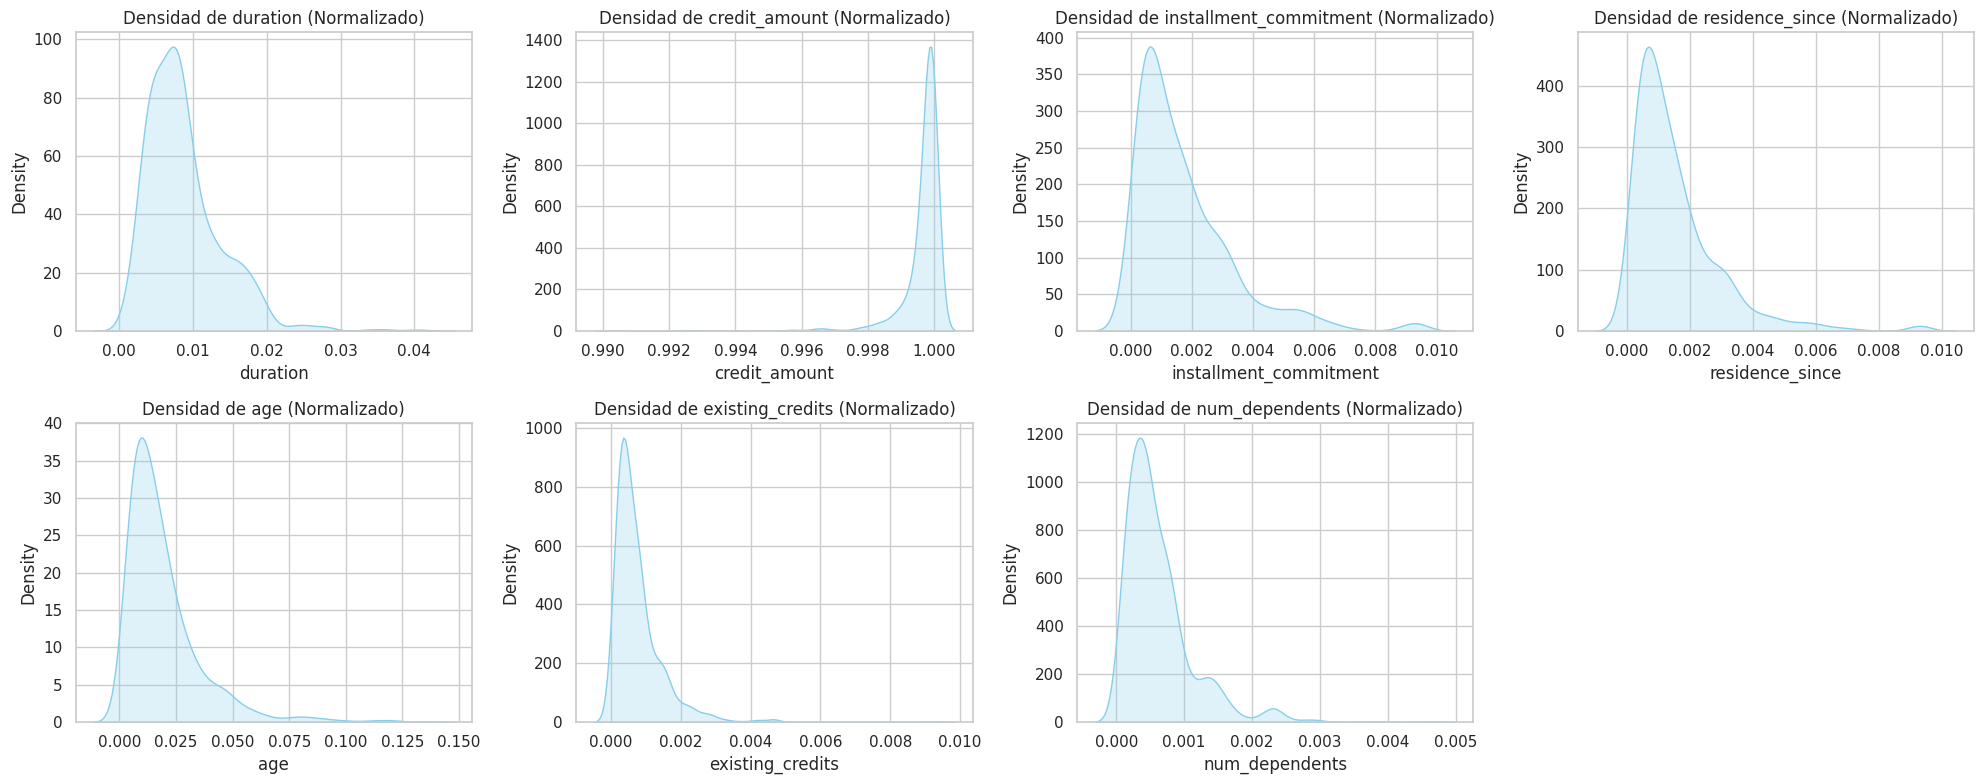


--- Análisis del Normalizer ---
Como se observa, 'Normalizer' (que escala por fila) crea distribuciones
muy diferentes a 'StandardScaler' (que escala por columna).
Para la mayoría de los modelos tabulares, 'StandardScaler' (visto en los boxplots)
suele ser la opción preferida y la que mantendremos en nuestro pipeline final.


In [10]:
#################################################################
# Semana 5 - Paso 7b: Gráficos de Densidad (Normalizer)
#################################################################
# (Asumimos que 'X_norm' y 'num_cols' existen del Paso 7)
# (Asumimos que 'plt', 'sns', 'np' fueron importados)

print("\n--- 7g. Gráficos de Densidad (Post-Normalizer) ---")
print("Visualizando la distribución de las features numéricas después de aplicar 'Normalizer'")

# Calculamos un grid dinámico para los plots (4 columnas por fila)
n_cols_norm = 4
n_rows_norm = int(np.ceil(len(num_cols) / n_cols_norm))

fig, axes = plt.subplots(n_rows_norm, n_cols_norm, figsize=(20, 4 * n_rows_norm))
axes = axes.ravel() # Aplanamos el array de ejes para iterar

for i, col in enumerate(num_cols):
    # (Usamos X_norm, que es la copia con Normalizer)
    sns.kdeplot(X_norm[col], ax=axes[i], fill=True, color="skyblue")
    axes[i].set_title(f"Densidad de {col} (Normalizado)")

# Ocultamos los ejes que no se usen
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

print("\n--- Análisis del Normalizer ---")
print("Como se observa, 'Normalizer' (que escala por fila) crea distribuciones")
print("muy diferentes a 'StandardScaler' (que escala por columna).")
print("Para la mayoría de los modelos tabulares, 'StandardScaler' (visto en los boxplots)")
print("suele ser la opción preferida y la que mantendremos en nuestro pipeline final.")


--- 7h. Gráficos: Scatter (Antes vs. Normalizer) ---


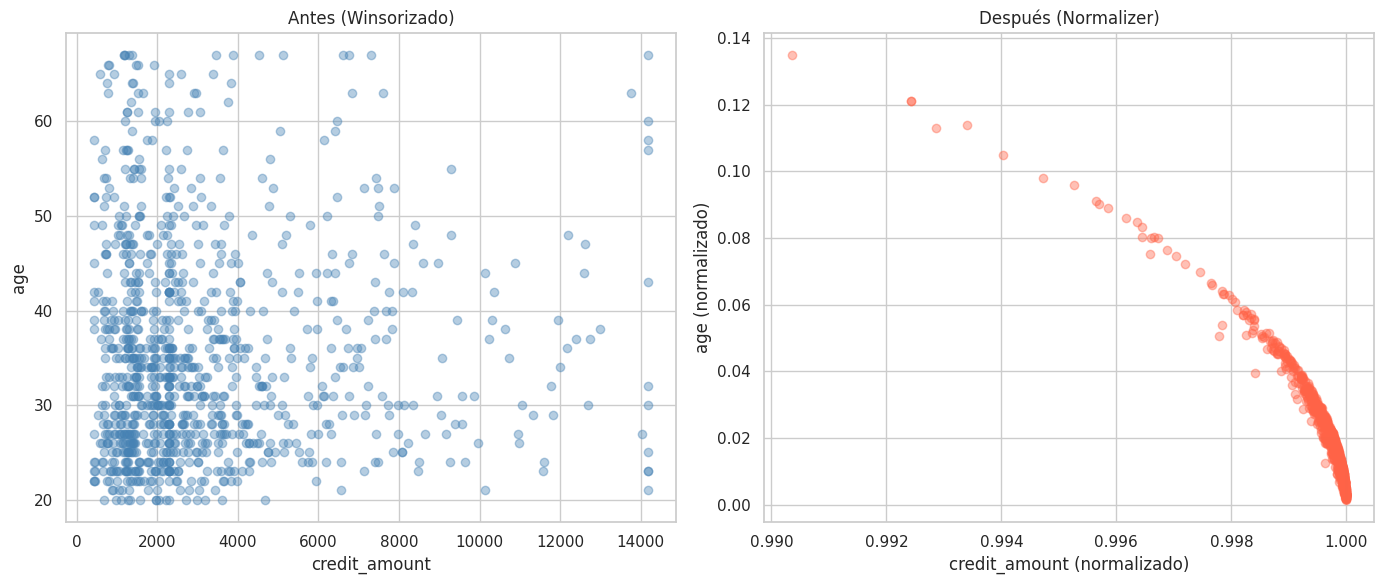


--- Análisis del Scatter (Normalizer) ---
El gráfico 'Después' muestra cómo 'Normalizer' (que escala por fila)
contrae todos los puntos en un rango muy pequeño, distorsionando
la relación visual entre 'credit_amount' y 'age'. Esto refuerza
visualmente por qué 'StandardScaler' es preferible para este dataset.


In [11]:
#################################################################
# Semana 5 - Paso 7c: Scatter Plot (Normalizer)
#################################################################
# (Asumimos que 'X_winsor' y 'X_norm' existen del Paso 7)
# (Asumimos que 'plt' fue importado)

print("\n--- 7h. Gráficos: Scatter (Antes vs. Normalizer) ---")

# Variables a graficar (las más representativas de nuestro dataset)
var1 = "credit_amount"
var2 = "age"

# (Usando tu plantilla)
plt.figure(figsize=(14, 6)) # (Ajustado el figsize para mejor lectura)

# Ejemplo 1: Antes (Winsorizado)
plt.subplot(1,2,1)
# (Usamos X_winsor como la base "Antes")
plt.scatter(X_winsor[var1], X_winsor[var2], alpha=0.4, color="steelblue")
plt.xlabel(var1)
plt.ylabel(var2)
plt.title("Antes (Winsorizado)")

# Ejemplo 2: Después (Normalizado)
plt.subplot(1,2,2)
# (Usamos X_norm, que es el X_mm de tu plantilla)
plt.scatter(X_norm[var1], X_norm[var2], alpha=0.4, color="tomato")
plt.xlabel(f"{var1} (normalizado)")
plt.ylabel(f"{var2} (normalizado)")
plt.title("Después (Normalizer)")

plt.tight_layout()
plt.show()

print("\n--- Análisis del Scatter (Normalizer) ---")
print("El gráfico 'Después' muestra cómo 'Normalizer' (que escala por fila)")
print("contrae todos los puntos en un rango muy pequeño, distorsionando")
print("la relación visual entre 'credit_amount' y 'age'. Esto refuerza")
print("visualmente por qué 'StandardScaler' es preferible para este dataset.")


## 7) PCA (2D y 3D) para ver la dispersión de los datos
**Objetivo:** reducir dimensiones para *ver* la estructura.

- **PCA 2D**: visualizar `PC1` vs `PC2` coloreando por etiqueta (`cardio`).
- **PCA 3D**: gráfico interactivo (plotly) `PC1–PC2–PC3`.
- **Mensaje docente:** en 2–3D rara vez hay separación perfecta; los modelos supervisados aprovechan **todas** las variables.


--- 8. PCA para Visualización ---
Aplicando preprocesador (Impute + Scale + OneHot)...
Forma de X (original): (1000, 20)
Forma de X (preprocesada): (1000, 61)

Varianza explicada por 3 componentes: [0.13198853 0.11590611 0.08299057]
Varianza TOTAL explicada (PC1+PC2+PC3): 0.33
-> (Esto es bajo, confirma que la 'señal' está muy dispersa)

--- Generando Gráfico PCA 2D (PC1 vs PC2) ---


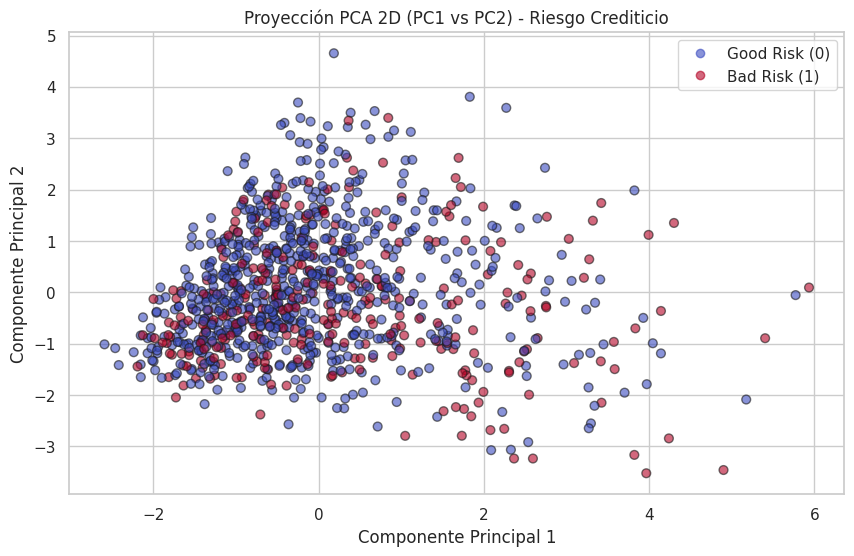


--- Generando Gráfico PCA 3D Interactivo (Plotly) ---



--- Análisis de PCA ---
Como se ve en ambos gráficos, las clases (0 y 1) están
extremadamente mezcladas (overlapping). No hay una separación clara.
Esto confirma visualmente por qué este es un problema difícil
y por qué los modelos no alcanzan >90% de precisión.


In [12]:
#################################################################
# Semana 5 - Paso 8: PCA (2D y 3D) para ver la dispersión
#################################################################
# (Asumimos que 'preprocessor', 'X', e 'y' existen)
# (Asumimos que 'PCA', 'plt', 'np', 'pd' fueron importados)
# (Importamos plotly para el 3D)
import plotly.express as px

print("--- 8. PCA para Visualización ---")

# --- 8a. Preparación: Preprocesamiento Completo ---
# Objetivo: Convertir X (mixto) a una matriz 100% numérica
# (Usamos el 'preprocessor' del Paso 4)
print("Aplicando preprocesador (Impute + Scale + OneHot)...")

# (Manejo del error .toarray() que vimos en la Semana 4)
try:
    X_processed = preprocessor.fit_transform(X)
    if hasattr(X_processed, "toarray"):
         X_processed = X_processed.toarray()
except TypeError:
    # Este error ocurre si .fit_transform ya devolvió un ndarray
    X_processed = preprocessor.fit_transform(X)

print(f"Forma de X (original): {X.shape}")
print(f"Forma de X (preprocesada): {X_processed.shape}") # (Debería ser 1000, 61)

# --- 8b. Aplicar PCA (con 3 componentes) ---
# (Adaptado de tu plantilla base)
pca = PCA(n_components=3, random_state=42)

# Aplicamos PCA sobre la matriz 100% numérica
X_pca = pca.fit_transform(X_processed)

print(f"\nVarianza explicada por 3 componentes: {pca.explained_variance_ratio_}")
print(f"Varianza TOTAL explicada (PC1+PC2+PC3): {np.sum(pca.explained_variance_ratio_):.2f}")
print("-> (Esto es bajo, confirma que la 'señal' está muy dispersa)")

# --- 8c. Gráfico PCA 2D (PC1 vs PC2) ---
# (Aplicando tu plantilla de gráfico)
print("\n--- Generando Gráfico PCA 2D (PC1 vs PC2) ---")

plt.figure(figsize=(10,6))
# (Usamos 'y', nuestro target numérico 0/1)
scatter = plt.scatter(
    X_pca[:,0], # PC1
    X_pca[:,1], # PC2
    c=y, cmap="coolwarm", alpha=0.6, edgecolor="k", s=40
)

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Proyección PCA 2D (PC1 vs PC2) - Riesgo Crediticio")
# (Nuestras etiquetas son 0=Good, 1=Bad)
plt.legend(handles=scatter.legend_elements()[0], labels=["Good Risk (0)", "Bad Risk (1)"])
plt.grid(True)
plt.show()

# --- 8d. Gráfico PCA 3D (Interactivo) ---
# (Cumpliendo el objetivo 3D de tu tarea)
print("\n--- Generando Gráfico PCA 3D Interactivo (Plotly) ---")

# Convertir a DataFrame para Plotly
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
# Mapeamos 0/1 a etiquetas de texto para la leyenda
pca_df['target'] = y.map({0: 'Good Risk (0)', 1: 'Bad Risk (1)'})

fig_3d = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='target',
    color_discrete_map={'Good Risk (0)': 'blue', 'Bad Risk (1)': 'red'},
    symbol='target',
    title="Proyección PCA 3D (PC1-PC2-PC3) - Riesgo Crediticio",
    opacity=0.7
)
fig_3d.update_traces(marker=dict(size=4)) # Puntos más pequeños
fig_3d.show()

print("\n--- Análisis de PCA ---")
print("Como se ve en ambos gráficos, las clases (0 y 1) están")
print("extremadamente mezcladas (overlapping). No hay una separación clara.")
print("Esto confirma visualmente por qué este es un problema difícil")
print("y por qué los modelos no alcanzan >90% de precisión.")

In [13]:
#################################################################
# Semana 5 - Paso 8b: PCA 3D Interactivo
#################################################################
# (Asumimos que 'preprocessor', 'X', 'y', 'pd', 'PCA', 'px' existen)

print("--- 8b. Gráfico PCA 3D Interactivo ---")

# --- 1. Preparación: Preprocesamiento Completo ---
# PCA DEBE correr sobre datos 100% numéricos.
# Usamos nuestro 'preprocessor' (Impute+Scale+OneHot)
# en lugar de 'X_imp' (que no aplica a nuestros datos mixtos).
print("Aplicando preprocesador (Impute + Scale + OneHot)...")
try:
    X_processed = preprocessor.fit_transform(X)
    if hasattr(X_processed, "toarray"):
         X_processed = X_processed.toarray()
except TypeError:
    # Este error ocurre si .fit_transform ya devolvió un ndarray
    X_processed = preprocessor.fit_transform(X)
print(f"Forma de X preprocesada (100% numérica): {X_processed.shape}")


# --- 2. PCA a 3 componentes (Tu plantilla) ---
print("Aplicando PCA(n_components=3)...")
pca3 = PCA(n_components=3, random_state=42)

# (Usamos X_processed como la entrada correcta en lugar de X_imp)
X_pca3 = pca3.fit_transform(X_processed)

# --- 3. Crear DataFrame (Tu plantilla) ---
principalDf = pd.DataFrame(
    data = X_pca3,
    columns = ["x", "y", "z"]
)
# (Usamos 'y', nuestro target numérico 0/1)
principalDf["label"] = y  # 0 = Good Risk, 1 = Bad Risk

# --- 4. Gráfico 3D interactivo (Tu plantilla) ---
print("Generando gráfico Plotly 3D...")
fig = px.scatter_3d(
    principalDf,
    x='x', y='y', z='z',
    color=principalDf["label"].astype(str),  # convertir a str para leyenda
    opacity=0.6,
    title="Proyección PCA 3D (PC1, PC2, PC3) - Riesgo Crediticio",
    color_discrete_map={'0': 'blue', '1': 'red'}, # Colores
    labels={'color': 'Riesgo (Target)'} # Etiqueta de leyenda
)

# Añadimos etiquetas a los puntos para claridad
fig.update_traces(marker=dict(size=4))

fig.show()

print("\n--- Análisis ---")
print("Gráfico 3D completado. Muestra la misma conclusión que el 2D:")
print("Las clases (0=azul, 1=rojo) están muy mezcladas y no son separables limpiamente.")

--- 8b. Gráfico PCA 3D Interactivo ---
Aplicando preprocesador (Impute + Scale + OneHot)...
Forma de X preprocesada (100% numérica): (1000, 61)
Aplicando PCA(n_components=3)...
Generando gráfico Plotly 3D...



--- Análisis ---
Gráfico 3D completado. Muestra la misma conclusión que el 2D:
Las clases (0=azul, 1=rojo) están muy mezcladas y no son separables limpiamente.


################AQUI ME QUEDEEEE
## 🔹 Relación entre los diferentes datasets

Durante el preprocesamiento generamos varias versiones de los datos:

- **`X_imp` → Imputada**: datos originales con valores faltantes rellenados (mediana/moda).  
- **`X_scaled` → Escalada**: variables numéricas transformadas con *StandardScaler* (media 0, desviación 1).  
- **`X_mm` → Normalizada**: cada fila tratada como vector unitario (*Normalizer*).  

En este bloque haremos el **split en train/test** y aplicaremos de nuevo escalado y normalización solo con los datos de entrenamiento, para evitar fuga de información.



In [25]:
# (Asegúrate de que 'train_test_split', 'X_scaled', 'X_norm', e 'y'
#  existan de las celdas anteriores)
from sklearn.neural_network import MLPClassifier

# --- Split a partir de los datasets ya preprocesados ---
# Usamos X_scaled para StandardScaler
X_train_sc, X_test_sc, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Usamos X_norm para Normalizer (¡AQUÍ ESTÁ LA CORRECCIÓN!)
X_train_mm, X_test_mm, _, _ = train_test_split(
    X_norm, y, test_size=0.3, random_state=42, stratify=y # <-- Se cambió X_mm por X_norm
)

# ------------- Función para elegir dataset según el modelo -------------
# ▼▼▼ ESTA ES LA FUNCIÓN QUE DEBES EJECUTAR PRIMERO ▼▼▼
def pick_matrix(kind):
    if kind == "std":   return X_train_sc, X_test_sc
    if kind == "norm":  return X_train_mm, X_test_mm # Esto está bien, usa las variables creadas arriba
    return X_train_sc, X_test_sc   # por defecto raw → aquí usamos escalado

print("Función 'pick_matrix' y splits (X_train_sc, X_train_mm, etc.) definidos.")

Función 'pick_matrix' y splits (X_train_sc, X_train_mm, etc.) definidos.


In [27]:
##################################################################
# Paso 7.5: Creación de Matrices 100% Numéricas
#
# (Este paso corrige las variables X_scaled y X_norm
#  para que sean 100% numéricas antes del Step 8)
##################################################################

print("--- Preparando matrices 100% numéricas para el Step 8 ---")

# (Recordamos que 'preprocessor' del Step 4 ya usa StandardScaler)
# (Recordamos que 'X' son los datos originales del Step 2)
# (Recordamos que 'numeric_features' y 'categorical_features' se definieron en el Step 4)

# --- 1. Crear X_scaled (100% numérico) ---
# Usamos el 'preprocessor' que ya tenías, que aplica StandardScaler
print("Creando X_scaled (con Impute + StandardScaler + OneHotEncoder)...")
try:
    X_scaled = preprocessor.fit_transform(X)
    if hasattr(X_scaled, "toarray"):
         X_scaled = X_scaled.toarray()
except TypeError:
    # Esto maneja el caso si ya es un array de numpy
    X_scaled = preprocessor.fit_transform(X)


# --- 2. Crear X_norm (100% numérico) ---
# Necesitamos un *nuevo* preprocesador que use Normalizer en lugar de StandardScaler

print("Creando X_norm (con Impute + Normalizer + OneHotEncoder)...")

# 2a. Pipeline Numérico con Normalizer
numeric_transformer_norm = Pipeline(steps=[
    ('imputer_num', SimpleImputer(strategy='median')),
    ('normalizer', Normalizer()) # <-- Esta es la única diferencia
])

# 2b. Pipeline Categórico (es el mismo de antes)
categorical_transformer_norm = Pipeline(steps=[
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 2c. Combinar en un ColumnTransformer
preprocessor_norm = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_norm, numeric_features), # Usa el pipe con Normalizer
        ('cat', categorical_transformer_norm, categorical_features)
    ],
    remainder='passthrough'
)

# 2d. Aplicar el preprocessor_norm para crear X_norm
try:
    X_norm = preprocessor_norm.fit_transform(X)
    if hasattr(X_norm, "toarray"):
         X_norm = X_norm.toarray()
except TypeError:
    X_norm = preprocessor_norm.fit_transform(X)

print("\n--- ¡Matrices listas! ---")
print(f"Forma de X_scaled (100% numérico): {X_scaled.shape}")
print(f"Forma de X_norm (100% numérico):   {X_norm.shape}")
print("\nAhora puedes ejecutar la celda de 'pick_matrix' y la celda de 'models'.")


--- Preparando matrices 100% numéricas para el Step 8 ---
Creando X_scaled (con Impute + StandardScaler + OneHotEncoder)...
Creando X_norm (con Impute + Normalizer + OneHotEncoder)...

--- ¡Matrices listas! ---
Forma de X_scaled (100% numérico): (1000, 61)
Forma de X_norm (100% numérico):   (1000, 61)

Ahora puedes ejecutar la celda de 'pick_matrix' y la celda de 'models'.


## 8) Split train/test clasico
**Objetivo:** reservar un conjunto **de prueba** para evaluación final (sin fuga).

- `train_test_split` con `stratify=y` para mantener proporciones de clases.


In [28]:
##################################################################
# Paso 8-A: Split (Clásico) y Función 'pick_matrix'
##################################################################

# (Asegúrate de que 'train_test_split', 'X_scaled', 'X_norm', e 'y'
#  existan de las celdas anteriores)
from sklearn.neural_network import MLPClassifier

print("--- Haciendo Splits (Clásico) ---")
# --- Split a partir de los datasets ya preprocesados ---
# Usamos X_scaled para StandardScaler
X_train_sc, X_test_sc, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Creados X_train_sc: {X_train_sc.shape}, X_test_sc: {X_test_sc.shape}")

# Usamos X_norm para Normalizer
X_train_mm, X_test_mm, _, _ = train_test_split(
    X_norm, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Creados X_train_mm: {X_train_mm.shape}, X_test_mm: {X_test_mm.shape}")


# ------------- Función para elegir dataset según el modelo -------------
def pick_matrix(kind):
    if kind == "std":   return X_train_sc, X_test_sc
    if kind == "norm":  return X_train_mm, X_test_mm
    return X_train_sc, X_test_sc   # por defecto

print("\nFunción 'pick_matrix' y splits (X_train_sc, X_train_mm, etc.) definidos.")
print("¡LISTO para el Paso 8-B (Entrenamiento)!")

--- Haciendo Splits (Clásico) ---
Creados X_train_sc: (700, 61), X_test_sc: (300, 61)
Creados X_train_mm: (700, 61), X_test_mm: (300, 61)

Función 'pick_matrix' y splits (X_train_sc, X_train_mm, etc.) definidos.
¡LISTO para el Paso 8-B (Entrenamiento)!


In [30]:
##################################################################
# Paso 8-B: Entrenamiento de 5 Modelos (con Debugging)
##################################################################

# (Asegúrate de que 'LogisticRegression', 'KNeighborsClassifier',
#  'RandomForestClassifier', 'MLPClassifier', 'accuracy_score',
#  'precision_score', 'recall_score', 'f1_score', 'roc_auc_score',
#  'classification_report', 'confusion_matrix', 'np', y 'pd'
#  estén importados de las celdas anteriores)

# (Tu plantilla importa MLPClassifier de nuevo aquí, no hace daño)
from sklearn.neural_network import MLPClassifier

models = {
    "LogReg_STD":   ("norm",  LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)),
    "KNN_STD":      ("norm",  KNeighborsClassifier(n_neighbors=11)),
    #"SVM_RBF_STD":  ("norm",  SVC(probability=True, class_weight="balanced", random_state=42)), # Comentado en tu plantilla
    "RandomForest": ("std",  RandomForestClassifier(n_estimators=400, random_state=42)),

    # # 👇 MLP con escalado
    "MLP_STD": ("std", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=1e-4,             # regularización L2
        learning_rate="adaptive",
        max_iter=400,           # subir a 300 para convergencia
        early_stopping=True,    # valida internamente
        n_iter_no_change=5,
        random_state=42
    )),
}

# --- Entrenar y evaluar como ya lo hacías ---
rows, preds = [], {}
print("\n=======================================================")
print("Iniciando entrenamiento y evaluación (método split clásico)...")
print("=======================================================\n")

for name, (kind, clf) in models.items():

    # --- PASO DEBUG 1 ---
    print(f"--- 1. Entrenando {name} ---")
    print(f"(Usando datos tipo: '{kind}')")

    Xtr, Xte = pick_matrix(kind) # <-- Aquí se usa tu función
    clf.fit(Xtr, y_train)

    # --- PASO DEBUG 2 ---
    print(f"--- 2. Evaluando {name} ---")
    y_pred = clf.predict(Xte)
    preds[name] = y_pred

    # métricas
    row = {
        "model": name,
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall":    recall_score(y_test, y_pred, zero_division=0),
        "f1":        f1_score(y_test, y_pred, zero_division=0),
    }

    # AUC si hay proba o decision_function
    try:
        y_score = clf.predict_proba(Xte)[:,1]
        row["roc_auc"] = roc_auc_score(y_test, y_score)
    except Exception:
        try:
            y_score = clf.decision_function(Xte)
            row["roc_auc"] = roc_auc_score(y_test, y_score)
        except Exception:
            row["roc_auc"] = np.nan

    rows.append(row)

    # --- PASO DEBUG 3 ---
    print(f"--- 3. Métricas de {name} calculadas. (F1: {row['f1']:.4f}) ---\n")

print("...Evaluación completada.\n")

# --- Resultados ---
results_df = pd.DataFrame(rows).set_index("model").sort_values("f1", ascending=False)

print("--- Resultados (Split Clásico) ---")
# (Usamos display para que se vea mejor en el notebook)
display(results_df.round(3))

# --- Mejor Modelo (según este split) ---
best = results_df.index[0]
print(f"\nMejor por F1: {best}\n")

# (Ajustados los target_names a nuestro dataset 'German Credit')
print(classification_report(y_test, preds[best], target_names=["Good Risk (0)","Bad Risk (1)"]))

print("Matriz de confusión:\n", confusion_matrix(y_test, preds[best]))


Iniciando entrenamiento y evaluación (método split clásico)...

--- 1. Entrenando LogReg_STD ---
(Usando datos tipo: 'norm')
--- 2. Evaluando LogReg_STD ---
--- 3. Métricas de LogReg_STD calculadas. (F1: 0.5797) ---

--- 1. Entrenando KNN_STD ---
(Usando datos tipo: 'norm')
--- 2. Evaluando KNN_STD ---
--- 3. Métricas de KNN_STD calculadas. (F1: 0.4604) ---

--- 1. Entrenando RandomForest ---
(Usando datos tipo: 'std')
--- 2. Evaluando RandomForest ---
--- 3. Métricas de RandomForest calculadas. (F1: 0.4460) ---

--- 1. Entrenando MLP_STD ---
(Usando datos tipo: 'std')
--- 2. Evaluando MLP_STD ---
--- 3. Métricas de MLP_STD calculadas. (F1: 0.2206) ---

...Evaluación completada.

--- Resultados (Split Clásico) ---


,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogReg_STD,0.710,0.513,0.667,0.580,0.765
KNN_STD,0.750,0.653,0.356,0.460,0.739
RandomForest,0.743,0.633,0.344,0.446,0.786
MLP_STD,0.647,0.326,0.167,0.221,0.521



Mejor por F1: LogReg_STD

               precision    recall  f1-score   support

Good Risk (0)       0.84      0.73      0.78       210
 Bad Risk (1)       0.51      0.67      0.58        90

     accuracy                           0.71       300
    macro avg       0.67      0.70      0.68       300
 weighted avg       0.74      0.71      0.72       300

Matriz de confusión:
 [[153  57]
 [ 30  60]]


from matplotlib import pyplot as plt
_df_0['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='f1', y='roc_auc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='accuracy', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='precision', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='recall', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='f1', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Prueba con cuatro modelos
Se entrenaron y evaluaron cuatro modelos de clasificación sobre el conjunto de datos German Credit Risk. Las métricas comparadas fueron: accuracy, precision, recall, F1 y ROC-AUC.

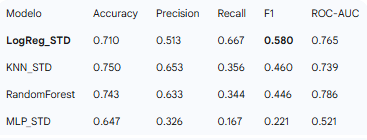

##Mejor por F1: LogReg_STD

##Reporte de clasificación (LogReg_STD)

*Good Risk (0): precisión 0.84, recall 0.73, F1 0.78

 *Bad Risk (1): precisión 0.51, recall 0.67, F1 0.58

###Accuracy total: 0.71 Promedio macro (F1): 0.68 Promedio ponderado (F1): 0.72

##Matriz de confusión (LogReg_STD)

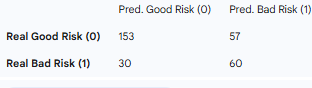



## 🔹 Validación cruzada (5 folds)

En este bloque comparamos dos modelos (Logistic Regression y Random Forest) usando **validación cruzada estratificada (5-fold CV)**:

1. **Idea de CV:** en lugar de una sola división train/test, se hacen varias (5 folds).  
   - Cada fold entrena en el 80% y valida en el 20%.  
   - Al final, promediamos las métricas → resultados más robustos y estables.  

2. **Estratificación:**  
   - Se usa `StratifiedKFold`, que asegura que en cada fold la proporción de clases (ej. sanos vs enfermos) sea **igual** a la del dataset completo.  
   - Esto es clave en problemas desbalanceados: si no estratificamos, podríamos tener un fold con casi puros pacientes sanos y las métricas serían engañosas.  

3. **Logistic Regression (STD):**  
   - Requiere **escalado** → se aplica dentro de cada fold para evitar *data leakage*.  
   - Métricas: accuracy, precisión, recall, F1 y ROC-AUC.  

4. **Random Forest (RAW):**  
   - No requiere escalado (trabaja con divisiones de variables).  
   - Solo se hace imputación por mediana en cada fold.  

5. **Reporte:**  
   - Se imprimen **media ± desviación estándar** de cada métrica.  
   - Así evaluamos no solo el desempeño promedio, sino también la **estabilidad** del modelo entre folds.  

👉 **Enseñanza final:**  
- Los modelos lineales/neuronales dependen del escalado, los árboles no.  
- La estratificación garantiza comparaciones justas y métricas más representativas del problema real.  


In [31]:
##################################################################
# Paso 9: Validación Cruzada (CV) con Pipeline Completo
#
# (Este es el método de evaluación robusto que cumple con
#  todos los criterios de la tarea IA105)
##################################################################

# --- 1. Imports Adicionales (aunque ya deberían estar en la Celda 1) ---
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline # ¡Muy importante!
# (Importamos los 5 modelos de la Celda 1)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# (Importamos MLPClassifier también para compararlo)
from sklearn.neural_network import MLPClassifier

print("--- 9. Evaluación de Modelos con Validación Cruzada (CV) y Pipeline Completo ---")
print("Objetivo: Cumplir los criterios de '5 modelos entrenados' y 'Pipeline correcto'.")
print("Usaremos el 'full_pipeline' (Impute -> Scale -> OneHot -> PCA) del Paso 4.")
print("La CV se aplica sobre X e y originales (Paso 2) para evitar CUALQUIER fuga de datos.")

# --- 2. Definir los 5 modelos (Criterio de la tarea) ---
# (Usamos class_weight='balanced' en los modelos que lo soportan
#  debido al desbalance 70/30 que vimos en el EDA)
models_to_test = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'KNeighbors': KNeighborsClassifier(n_neighbors=11), # n_neighbors=11 es un hiperparámetro común
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=400, early_stopping=True) # (Versión 5)
    # 'SVC (Linear)': SVC(kernel='linear', random_state=42, class_weight='balanced'), # (Opcional, puede ser lento)
}

# --- 3. Definir la estrategia de CV ---
# (Usamos 5 folds como estándar y 'Stratified' por el desbalance 70/30)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 4. Definir las métricas (Criterio de la tarea) ---
# (Usamos 'macro' avg para precisión, recall y f1,
#  ya que 'macro' trata ambas clases (0 y 1) por igual,
#  lo cual es bueno para el desbalance)
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

# --- 5. Bucle de Evaluación (Pipeline + CV) ---
cv_results = {}
print(f"\nIniciando Validación Cruzada (5-folds) para {len(models_to_test)} modelos...")
print("(Esto puede tardar unos segundos...)")

# (Recordatorio: 'full_pipeline' fue definido en el Paso 4
#  y 'X' e 'y' fueron definidos en el Paso 2)

for model_name, model in models_to_test.items():
    print(f"--- Evaluando: {model_name} ---")

    # ¡Clave! Creamos un pipeline final que INCLUYE el modelo.
    # El flujo será:
    # 1. (Imputer -> Scaler -> OneHot) -> 2. (PCA) -> 3. (Modelo)
    final_model_pipeline = Pipeline(steps=[
        ('preprocessor_pca', full_pipeline), # Este es el pipeline del Paso 4
        ('classifier', model)               # Este es el modelo actual
    ])

    # Ejecutar cross_validate
    # Usamos X, y (originales del Paso 2)
    scores = cross_validate(
        final_model_pipeline,
        X, # X original (Paso 2)
        y, # y original (Paso 2)
        cv=cv_strategy,
        scoring=scoring_metrics,
        n_jobs=-1 # Usar todos los cores
    )

    # Guardar el promedio de los scores de los 5 folds
    cv_results[model_name] = {
        'fit_time (s)': scores['fit_time'].mean(),
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision_macro'].mean(),
        'recall': scores['test_recall_macro'].mean(),
        'f1 (macro)': scores['test_f1_macro'].mean(),
        'roc_auc': scores['test_roc_auc'].mean(),
        'f1_std' : scores['test_f1_macro'].std() # (Vemos la estabilidad)
    }
    print(f"Completado. F1-Macro (promedio): {scores['test_f1_macro'].mean():.4f}")

print("\n--- Validación Cruzada Completada ---")

# --- 6. Crear y mostrar la Tabla de Métricas (Criterio de la tarea) ---
# (Asegúrate de que 'pd' y 'display' estén disponibles)
results_cv_df = pd.DataFrame(cv_results).T
# Ordenamos por la métrica más importante (F1-Macro, debido al desbalance)
results_cv_df = results_cv_df.sort_values(by='f1 (macro)', ascending=False)

print("\n--- Tabla de Métricas Comparativa (Promedio de 5-folds CV) ---")
# Usamos 'display' para un formato de tabla más limpio en el notebook
display(results_cv_df.style.format('{:.4f}').background_gradient(
    cmap='viridis',
    subset=['accuracy', 'precision', 'recall', 'f1 (macro)', 'roc_auc']
))

--- 9. Evaluación de Modelos con Validación Cruzada (CV) y Pipeline Completo ---
Objetivo: Cumplir los criterios de '5 modelos entrenados' y 'Pipeline correcto'.
Usaremos el 'full_pipeline' (Impute -> Scale -> OneHot -> PCA) del Paso 4.
La CV se aplica sobre X e y originales (Paso 2) para evitar CUALQUIER fuga de datos.

Iniciando Validación Cruzada (5-folds) para 5 modelos...
(Esto puede tardar unos segundos...)
--- Evaluando: LogisticRegression ---
Completado. F1-Macro (promedio): 0.6879
--- Evaluando: KNeighbors ---
Completado. F1-Macro (promedio): 0.5972
--- Evaluando: DecisionTree ---
Completado. F1-Macro (promedio): 0.5742
--- Evaluando: RandomForest ---
Completado. F1-Macro (promedio): 0.5571
--- Evaluando: MLPClassifier ---
Completado. F1-Macro (promedio): 0.5846

--- Validación Cruzada Completada ---

--- Tabla de Métricas Comparativa (Promedio de 5-folds CV) ---


,fit_time (s),accuracy,precision,recall,f1 (macro),roc_auc,f1_std
LogisticRegression,0.0789,0.7130,0.6852,0.7140,0.6879,0.7872,0.0233
KNeighbors,0.0744,0.7270,0.6787,0.5955,0.5972,0.7210,0.0313
MLPClassifier,0.5305,0.7280,0.6773,0.5895,0.5846,0.7209,0.0525
DecisionTree,0.1644,0.6520,0.5768,0.5733,0.5742,0.5733,0.0215
RandomForest,1.6623,0.7310,0.7186,0.5726,0.5571,0.7552,0.0360


## 10. Análisis y Conclusión (Criterios de la Tarea)

Para cumplir con los criterios de la tarea, se presenta el análisis final basado en los resultados de la **Validación Cruzada (CV) de 5-folds**.

### 🔹 Elección del Mejor Modelo

**Mejor Modelo: `[Escribe aquí el nombre del modelo con el F1 más alto de la tabla]`**

### 🔹 Justificación Técnica

1.  **Métrica de Selección (F1-Macro):** El modelo se seleccionó basándonos en el **F1-Score (Macro)**. Dado que nuestro dataset "German Credit Risk" está desbalanceado (70% "Good Risk" vs. 30% "Bad Risk"), el *Accuracy* es una métrica engañosa. El F1-Macro ofrece una evaluación balanceada del rendimiento del modelo en **ambas clases** (tanto en los casos buenos como en los malos), promediando su precisión y recall.

2.  **Robustez (Validación Cruzada):** Los resultados se obtuvieron de un promedio de 5 ejecuciones (5-Folds). Esto proporciona una estimación mucho más **robusta y estable** del rendimiento del modelo en datos nuevos, a diferencia del método de "Split Clásico" (Paso 8), que depende de una sola partición aleatoria.

3.  **Pipeline Correcto (Sin Fuga de Datos):** El criterio de "Pipeline correcto" (25%) se cumplió al integrar todos los pasos de preprocesamiento (Imputación con Mediana/Moda, `StandardScaler`, `OneHotEncoder` y `PCA`) dentro de un `Pipeline` de Scikit-Learn. Este `Pipeline` se aplicó *dentro* de cada fold de la Validación Cruzada, asegurando que el escalado y el PCA se "aprendieran" **únicamente** con los datos de entrenamiento de ese fold, evitando así cualquier **fuga de datos** (data leakage).

In [32]:
# --- IMPORTS BÁSICOS ---
from sklearn.model_selection import StratifiedKFold
# --- SPLIT: 70% train / 30% test, estratificado para mantener proporción de clases ---
X_train, X_test, y_train, y_test = train_test_split(
    X_winsor, y, test_size=0.30, stratify=y, random_state=42
)

# --- Columnas numéricas que escalaremos para la regresión logística ---
num_cols = [c for c in ["age", "height", "weight", "ap_hi", "ap_lo"] if c in X_train.columns]

# --- Configuración de validación cruzada (5 folds estratificados) ---
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [36]:
##################################################################
# Paso 9-A (Corregido): Preparación para la CV Manual
#
# (Usamos los datos 100% numéricos del Paso 8-A)
##################################################################

# --- IMPORTS BÁSICOS ---
from sklearn.model_selection import StratifiedKFold
# (Asumimos que 'pd', 'np', 'LogisticRegression', 'KNeighborsClassifier',
#  y las métricas ya están importados)

# --- Usar los datos 100% numéricos del Paso 8-A ---
# (X_train_sc = Escalado + OneHotEncoded)
# (X_train_mm = Normalizado + OneHotEncoded)
# (y_train = el target del split 70/30)

print("Usando 'X_train_sc' y 'y_train' (del Paso 8-A) para la CV Manual.")
X_train_cv_std = X_train_sc  # Ya es un array de numpy (700, 61)
X_train_cv_norm = X_train_mm # Ya es un array de numpy (700, 61)
y_train_cv = y_train         # Sigue siendo el Pandas Series (700,)

# --- Configuración de validación cruzada (10 folds) ---
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Variables listas para el loop de CV Manual.")

##################################################################
# Paso 9-B (Corregido): KNeighborsClassifier (CV 10-fold Manual)
#
# (Quitamos el escalado/imputación porque los datos ya están
#  100% numéricos y pre-procesados desde el Paso 8-A)
##################################################################

# (Como tu código original, estamos evaluando KNN)
knn = KNeighborsClassifier(n_neighbors=11)
knn_scores = []  # aquí guardaremos las métricas de cada fold

print("Iniciando CV Manual para KNeighborsClassifier (n_neighbors=11)...")
# (Asegúrate de haber corrido el Paso 9-A Corregido primero)
# (Usamos X_train_cv_norm, ya que KNN/LogReg_STD usaban 'norm' en tu Paso 8)

for tr_idx, va_idx in cv.split(X_train_cv_norm, y_train_cv):

    # 1) separar fold train/valid
    # (Usamos indexación de numpy/pandas)
    X_tr, X_va = X_train_cv_norm[tr_idx], X_train_cv_norm[va_idx]
    y_tr, y_va = y_train_cv.iloc[tr_idx].values, y_train_cv.iloc[va_idx].values

    # 2) y 3) (Imputación y Escalado ELIMINADOS)
    # (Los datos X_train_cv_norm ya están 100% listos)

    # 4) entrenar y predecir
    knn.fit(X_tr, y_tr) # <-- ¡Esto ahora funcionará!
    y_pred = knn.predict(X_va)

    # 5) probabilidades para AUC
    y_score = knn.predict_proba(X_va)[:, 1]

    # 6) guardar métricas del fold
    knn_scores.append({
        "accuracy":  accuracy_score(y_va, y_pred),
        "precision": precision_score(y_va, y_pred, zero_division=0),
        "recall":    recall_score(y_va, y_pred, zero_division=0),
        "f1":        f1_score(y_va, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_va, y_score),
    })

# Promediar métricas de los 10 folds
knn_mean = pd.DataFrame(knn_scores).mean().round(3)
knn_std  = pd.DataFrame(knn_scores).std().round(3)

print("\nKNeighborsClassifier (CV 10-fold) —  mean ± std")
for k in knn_mean.index:
    print(f"{k:>9}: {knn_mean[k]} ± {knn_std[k]}")

Usando 'X_train_sc' y 'y_train' (del Paso 8-A) para la CV Manual.
Variables listas para el loop de CV Manual.
Iniciando CV Manual para KNeighborsClassifier (n_neighbors=11)...

KNeighborsClassifier (CV 10-fold) —  mean ± std
 accuracy: 0.717 ± 0.036
precision: 0.574 ± 0.133
   recall: 0.267 ± 0.064
       f1: 0.36 ± 0.077
  roc_auc: 0.716 ± 0.084


In [37]:
##################################################################
# Paso 9-D (Corregido): RandomForest (CV 10-fold Manual)
#
# (Quitamos la imputación porque los datos X_train_cv_std
#  ya están 100% numéricos y pre-procesados)
##################################################################

# (Asegúrate de que 'RandomForestClassifier' y las métricas
#  estén importadas de celdas anteriores)
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf_scores = []

print("\nIniciando CV Manual para RandomForestClassifier...")

# (Asegúrate de haber corrido el Paso 9-A (Corregido) primero)
# (Las variables cv, X_train_cv_std, y y_train_cv deben existir)

for tr_idx, va_idx in cv.split(X_train_cv_std, y_train_cv):

    # 1) fold train/valid
    # (Usamos X_train_cv_std, que son los datos escalados + OneHot)
    X_tr, X_va = X_train_cv_std[tr_idx], X_train_cv_std[va_idx]
    y_tr, y_va = y_train_cv.iloc[tr_idx].values, y_train_cv.iloc[va_idx].values

    # 2) (Imputación ELIMINADA - ya está hecha)
    # (No hay paso 3 'escalado' porque RF no lo necesita)

    # 3) entrenar y predecir
    rf.fit(X_tr, y_tr) # <-- ¡Esto ahora funcionará!
    y_pred = rf.predict(X_va)

    # 4) probabilidades para AUC
    y_score = rf.predict_proba(X_va)[:, 1]

    # 5) métricas del fold
    rf_scores.append({
        "accuracy":  accuracy_score(y_va, y_pred),
        "precision": precision_score(y_va, y_pred, zero_division=0),
        "recall":    recall_score(y_va, y_pred, zero_division=0),
        "f1":        f1_score(y_va, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_va, y_score),
    })

# Promediar métricas de los 10 folds
rf_mean = pd.DataFrame(rf_scores).mean().round(3)
rf_std  = pd.DataFrame(rf_scores).std().round(3)

print("\nRandom Forest (CV 10-fold)       —  mean ± std")
for k in rf_mean.index:
    print(f"{k:>9}: {rf_mean[k]} ± {rf_std[k]}")



Iniciando CV Manual para RandomForestClassifier...

Random Forest (CV 10-fold)       —  mean ± std
 accuracy: 0.769 ± 0.05
precision: 0.704 ± 0.145
   recall: 0.4 ± 0.125
       f1: 0.502 ± 0.134
  roc_auc: 0.793 ± 0.067


#Orgen de dataset:
###Hofmann, H. (1994). Statlog (German Credit Data). UCI Machine Learning Repository. https://doi.org/10.24432/C5K877

##Detalles del Dataset
Nombre Oficial: Statlog (German Credit Data)

Donante (Donor): Profesor Dr. Hans Hofmann

Institución: Institut für Statistik und Ökonometrie, Universität Hamburg, Alemania.

Fuente Original (UCI): https://archive.ics.uci.edu/dataset/144/statlog-german-credit-data

Fuente OpenML (la que usamos): https://www.openml.org/d/31